In [1]:
import pandas as pd
import numpy as np
import requests
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for dates
from datetime import timedelta, datetime

#modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
# read in the csv file
df = pd.read_csv('saas.csv')

df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
df.shape

(790458, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.Month_Invoiced.nlargest

<bound method Series.nlargest of 0         2014-01-31
1         2014-01-31
2         2014-01-31
3         2014-01-31
4         2014-01-31
             ...    
790453    2017-12-31
790454    2017-12-31
790455    2017-12-31
790456    2017-12-31
790457    2017-12-31
Name: Month_Invoiced, Length: 790458, dtype: object>

In [6]:
# convert all columns to lower case
df.columns = df.columns.str.lower()

In [7]:
# convert the sale date to a datetime
df.month_invoiced = pd.to_datetime(df['month_invoiced'])
# make that value our index value
df = df.set_index('month_invoiced').sort_index()

In [8]:
#look at data
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,790458.0,1.012913e+06,7591.991578,1000000.0,1006405.00,1012797.0,1019154.00,1029399.0
invoice_id,790458.0,5.395228e+06,228185.713880,5000000.0,5197614.25,5395228.5,5592842.75,5790457.0
subscription_type,790458.0,5.992349e-01,0.950380,0.0,0.00,0.0,1.00,4.0
amount,790458.0,2.996174e+00,4.751901,0.0,0.00,0.0,5.00,20.0


In [10]:
# resample by year
df_resampled = df.resample('m')[['amount']].sum()

# display the resampled dataframe
df_resampled

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


### 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:

In [11]:
def prep_store_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    # convert all columns to lower case
    df.columns = df.columns.str.lower()
    # convert the sale date to a datetime
    df.month_invoiced = pd.to_datetime(df['month_invoiced'])
    # make that value our index value
    df = df.set_index('month_invoiced').sort_index()
    # resample by year
    df_resampled = df.resample('m')[['amount']].sum()
    # display the resampled dataframe
    df_resampled
    return df_resampled

In [12]:
df = prep_store_data(df_resampled)

KeyError: 'month_invoiced'

In [13]:
df.head(10)

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
2014-01-31,1000005,5000005,2.0,10.0
2014-01-31,1000006,5000006,0.0,0.0
2014-01-31,1000007,5000007,0.0,0.0
2014-01-31,1000008,5000008,0.0,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        790458 non-null  int64  
 1   invoice_id         790458 non-null  int64  
 2   subscription_type  790458 non-null  float64
 3   amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [15]:
# split the data into training and test sets
train = df.loc['2014':'2016']
test = df.loc['2017']

# display the number of rows in each set
print('Number of rows in training set:', len(train))
print('Number of rows in test set:', len(test))

Number of rows in training set: 618169
Number of rows in test set: 172289


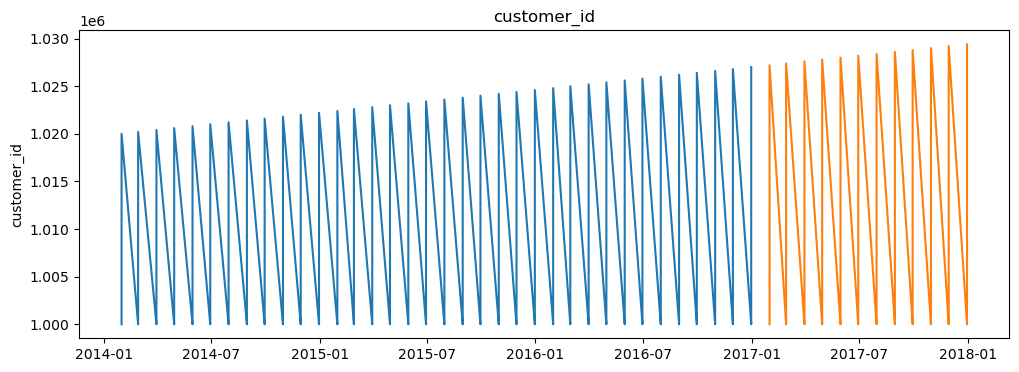

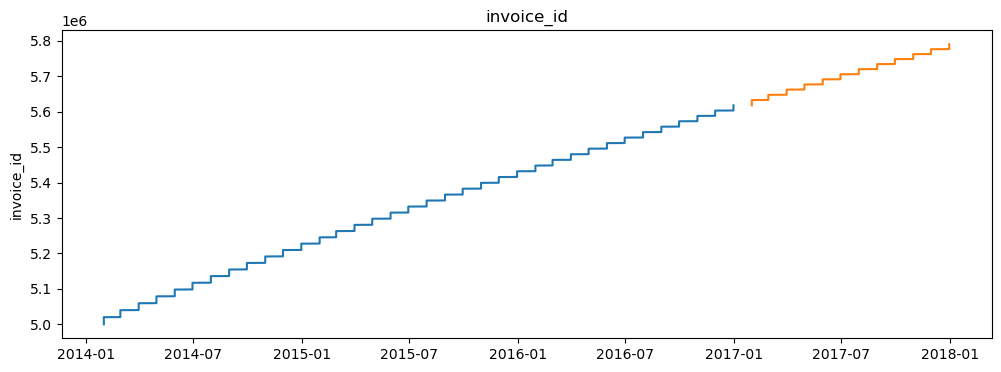

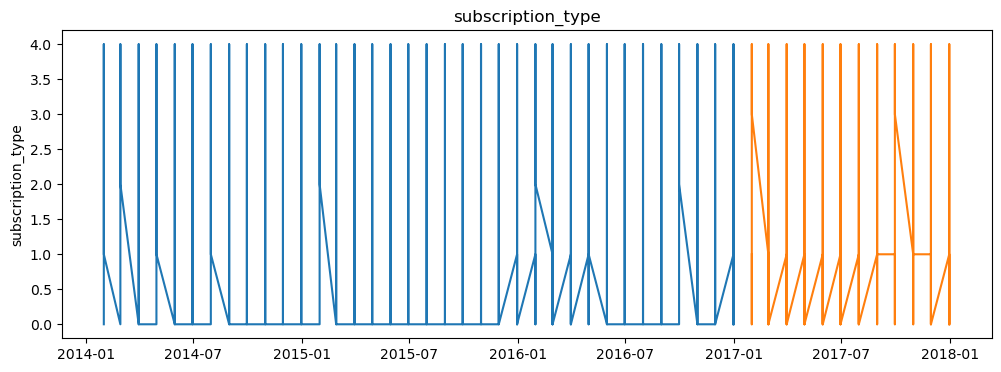

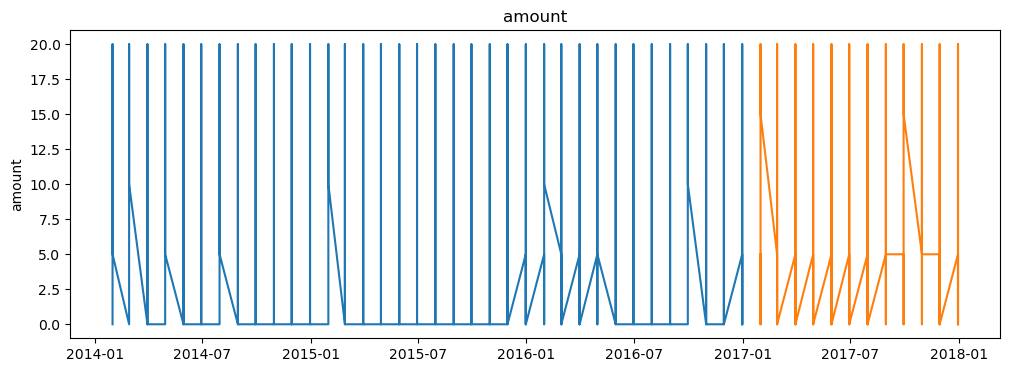

In [16]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
   
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [17]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            train[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

In [18]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
  
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

In [19]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [20]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

### Last Observed Value

In [21]:
# going forward from the -1st element in train's sales total, then 
# rip out the value associated with it by taking the zeroth element of that return
train['amount'][-1:][0]

0.0

In [22]:
# take the last item of sales total and assign to variable
# indexing: last thing to the end, then the first element
last_amount = train['amount'][-1:][0]

# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'amount': [last_amount],
    },
    index = train.index
)

In [23]:
yhat_df.head()

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0


KeyError: 'customer_id'

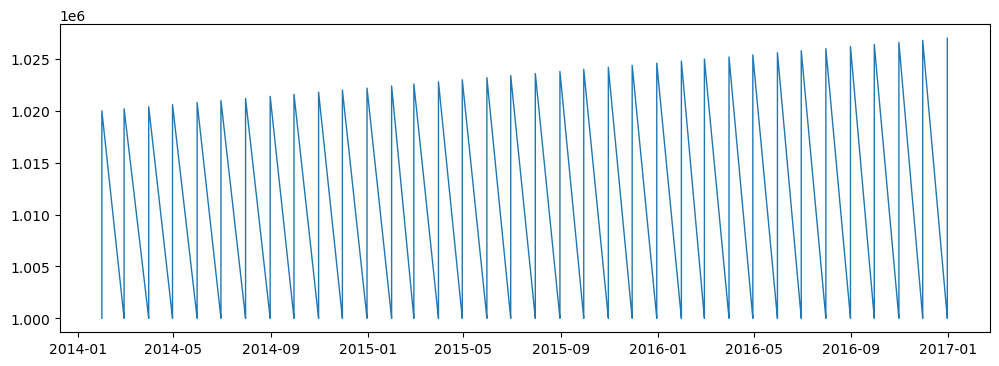

In [24]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

In [25]:
eval_df

,model_type,target_var,rmse


In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

KeyError: 'customer_id'

In [27]:
eval_df

,model_type,target_var,rmse


### Simple Average

In [28]:
# compute simple average of sales_total (from train data)
avg_amount = round(train['amount'].mean(), 2)

yhat_df = pd.DataFrame({'amount': [avg_amount]},
                        index=train.index)

yhat_df.head(3)

,amount
month_invoiced,
2014-01-31,2.79
2014-01-31,2.79
2014-01-31,2.79


KeyError: 'customer_id'

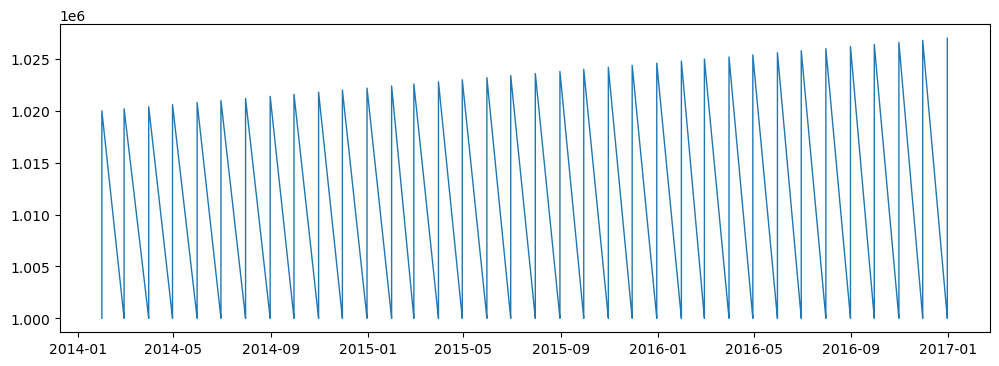

In [29]:
for col in train.columns:
    plot_and_eval(col)

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

KeyError: 'customer_id'

### Moving Average

In [31]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_amount = round(
    train['amount'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': rolling_amount},
                         index=train.index)
yhat_df.head()

,amount
month_invoiced,
2014-01-31,1.0
2014-01-31,1.0
2014-01-31,1.0
2014-01-31,1.0
2014-01-31,1.0


KeyError: 'customer_id'

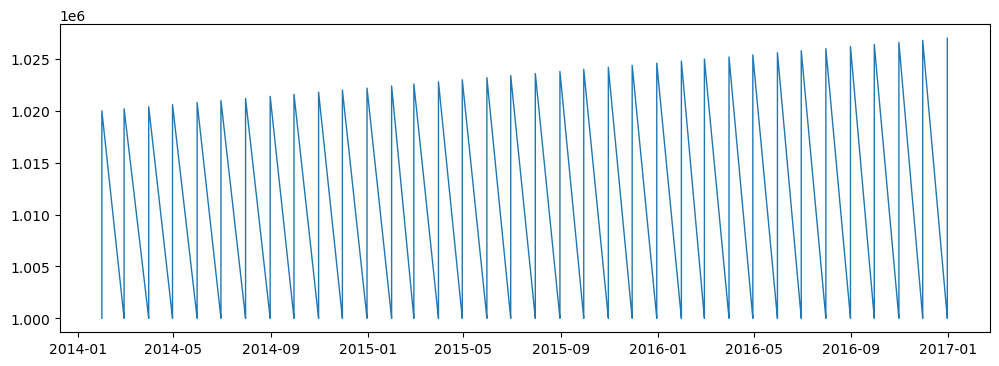

In [32]:
for col in train.columns:
    plot_and_eval(col)

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

KeyError: 'customer_id'

customer_id 



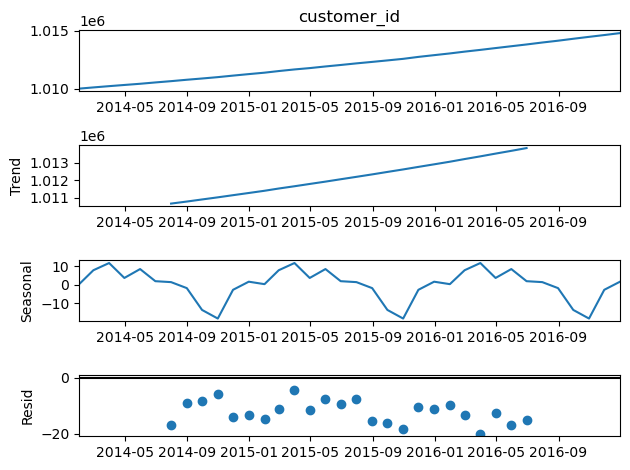

In [34]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [35]:
train.columns

Index(['customer_id', 'invoice_id', 'subscription_type', 'amount'], dtype='object')

In [36]:
col = 'amount' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
# fit the holt's object
model = model.fit(optimized=True)

In [38]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

NameError: name 'validate' is not defined

In [ ]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])